# First analysis part
    Preprocess text
    Word Frequency
    Bigrams
    W2V embeddings for NN
---

In [1]:
# Standard data manipulation and text processing libraries
import numpy as np
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import words
from nltk.corpus import stopwords

# Download NLTK datasets
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('words')

# Stop words and language processing tools
stop_words = set(stopwords.words('english'))
stop_words.add("None")

# Spacy for advanced text processing
import spacy

# Load Spacy language model
nlp = spacy.load("en_core_web_sm")

# Gensim for word embeddings
from gensim.models import Word2Vec

# Dimensionality reduction
from sklearn.decomposition import PCA

# Visualization libraries
import matplotlib.pyplot as plt

# Multiprocessing for parallelization
from multiprocessing import cpu_count
import concurrent.futures
from tqdm import tqdm

# Other utilities
from collections import Counter
import json
import string

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/trinidadbosch/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/trinidadbosch/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/trinidadbosch/nltk_data...
[nltk_data]   Package words is already up-to-date!


## Preprocess
---

In [2]:
%pwd

'/Users/trinidadbosch/Desktop/SEDS/MA-Thesis/thesis-env/Media Cloud/scripts'

In [17]:
##load data
data = pd.read_pickle('/Users/trinidadbosch/Desktop/SEDS/MA-Thesis/thesis-env/Media Cloud/Data/Final Data/final-news-data.pkl')

### Preprocess text
---

In [6]:
# Load spaCy model with only the tokenizer, tagger, and lemmatizer enabled
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Function to clean and lemmatize text
def preprocessing(texts):  # takes a list of texts as input
    cleaned_texts = (re.sub(r'[^a-zA-Z0-9\s]|(\n+)', ' ', str(text)).strip() for text in texts)
    
    # Process texts as a stream using nlp.pipe
    for doc in nlp.pipe(cleaned_texts, batch_size=100):  # batch size can be adjusted
        yield [token.lemma_.lower() for token in doc]
#Function to remove stopwords from a list of tokens
def remove_stopwords(tokens):
    return [token for token in tokens if token.lower() not in stop_words]

In [7]:
# Apply preprocessing function to 'Body' and 'Title' columns in batches
data['Cleaned_Body'] = list(preprocessing(data['Body'].tolist()))
data['Cleaned_Title'] = list(preprocessing(data['Title'].tolist()))

In [8]:
# Apply remove_stopwords 
data['Cleaned_Body_sw'] = data['Cleaned_Body'].apply(remove_stopwords)
data['Cleaned_Title_sw'] = data['Cleaned_Title'].apply(remove_stopwords)

### Preprocess dates
---

In [18]:
data.collect_date.isnull().any()

False

In [11]:
# Inspect unique date formats to find inconsistencies
# This helps in understanding the variety of formats present
unique_formats = data['collect_date'].apply(lambda x: x.strip()).unique()
print(unique_formats[:10])  # Print a sample of unique date formats to check for inconsistencies

AttributeError: 'Timestamp' object has no attribute 'strip'

In [19]:
data['collect_date_'] = pd.to_datetime(data['collect_date'], errors='coerce')

In [24]:
nan_rows = data[data['collect_date_'].isna()]
print(nan_rows['collect_date_'])  # Assuming the original 'collect_date' is still a string here or use another identifier column.
nan_rows

4285    NaT
4286    NaT
4287    NaT
4288    NaT
4289    NaT
         ..
82149   NaT
82152   NaT
82156   NaT
82163   NaT
90396   NaT
Name: collect_date_, Length: 673, dtype: datetime64[ns]


,ID,URL,Body,Title,collect_date,feeds,media_name,publish_date,stories_id,story_tags,title,Summary,Cleaned_Body,Cleaned_Title,collect_date_
4285,170602837,http://www.forbes.com/sites/nextavenue/2013/10...,"\nThinkstock\n\nBy Donna Sapolin, Next Avenue ...",The 5 Things That Really Spook People Over 50,2013-10-31 13:21:28,NaN,Forbes,2013-10-31 12:52:00,170602837,[],The 5 Things That Really Spook People Over 50,NaN,"[thinkstock, by, donna, sapolin, , next, aven...","[the, 5, thing, that, really, spook, people, o...",NaT
4286,187471100,http://www.forbes.com/sites/hollieslade/2013/1...,"\nAli Hamed, cofounder of CoVenture. (Credit: ...",How CoVenture's Founder Went From Sleeping In ...,2013-12-19 18:24:57,NaN,Forbes,2013-12-19 18:20:00,187471100,[],Comeback Kid: How CoVenture's Founder Went Fro...,NaN,"[ali, hamed, , cofounder, of, coventure, , ...","[how, coventure, s, founder, go, from, sleep, ...",NaT
4287,206531658,http://www.forbes.com/sites/lydiadishman/2014/...,It’s kind of like the holy grail for online re...,"Highly Personal, Very Private BloomReach SNAP ...",2014-02-25 21:33:17,NaN,Forbes,2014-02-25 21:17:00,206531658,[],"Highly Personal, Very Private BloomReach SNAP ...",NaN,"[it, s, kind, of, like, the, holy, grail, for,...","[highly, personal, , very, private, bloomreac...",NaT
4288,204865926,http://www.forbes.com/sites/zinamoukheiber/201...,\nUsing the natural language processing techno...,IBM And Epic Apply Predictive Analytics To Ele...,2014-02-20 02:17:28,NaN,Forbes,2014-02-19 18:59:00,204865926,[],IBM And Epic Apply Predictive Analytics To Ele...,NaN,"[use, the, natural, language, processing, tech...","[ibm, and, epic, apply, predictive, analytics,...",NaT
4289,181955002,http://www.forbes.com/sites/gregsatell/2013/12...,"\nWorking with IBM, the Memphis Police Dept. m...","Yes, Big Data Can Solve Real World Problems",2013-12-03 06:50:48,NaN,Forbes,2013-12-03 06:45:00,181955002,[],"Yes, Big Data Can Solve Real World Problems",NaN,"[work, with, ibm, , the, memphis, police, dep...","[yes, , big, data, can, solve, real, world, p...",NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82149,302055705,http://www.politico.com/morningmoney/1214/morn...,Romney/Bush lead in GOP poll — Russia hikes ra...,Romney/Bush lead in GOP poll — Russia hikes ra...,2014-12-16 20:46:51,NaN,Politico,2014-12-16 13:00:23,302055705,[],Romney/Bush lead in GOP poll — Russia hikes ra...,Romney/Bush lead in GOP poll — Russia hikes ra...,"[romney, bush, lead, in, gop, poll, , russia...","[romney, bush, lead, in, gop, poll, , russia...",NaT
82152,859682618,http://www.businessinsider.com/artificial-inte...,Ray Dalio. Larry Busacca/Getty\n\nThe world's ...,Billionaire hedge fund manager Ray Dalio — who...,2018-04-26 16:38:52,NaN,Business Insider,2015-02-27 07:00:00,859682618,"[{'stories_id': 859682618, 'tag': 'spidered', ...",Billionaire hedge fund manager Ray Dalio — who...,Larry Busacca/GettyThe world's largest hedge f...,"[ray, dalio, , larry, busacca, getty, the, wo...","[billionaire, hedge, fund, manager, ray, dalio...",NaT
82156,859684603,http://www.huffingtonpost.co.uk/2014/10/03/ame...,"Amelia is a pleasant, bright, professional. Sh...",Amelia: IPsoft's New Artificial Intelligence C...,2018-04-26 16:41:10,NaN,HuffPost,2014-10-03 11:31:29,859684603,"[{'stories_id': 859684603, 'tag': 'readability...",Amelia: IPsoft's New Artificial Intelligence C...,Amelia is a new type of artificial intelligenc...,"[amelia, be, a, pleasant, , bright, , profes...","[amelia, , ipsoft, s, new, artificial, intell...",NaT
82163,689832395,https://theintercept.com/2015/08/03/life-unmas...,I STEPPED FROM the warmth of our source’s Lond...,My Life Unmasking British Eavesdroppers,2017-09-14 06:36:44,NaN,Intercept,2015-08-03 08:00:00,689832395,[],My Life Unmasking British Eavesdroppers,"She had kept a war souvenir, a flirtatious poe...","[i, stepped, from, the, warmth, of, our, sourc...","[my, life, unmask, british, eavesdropper]",NaT


In [25]:
nan_rows['collect_date_']= pd.to_datetime(nan_rows['collect_date'], format='%Y-%m-%d %H:%M:%S',errors='coerce')
nan_rows

/tmp/ipykernel_33/3718394575.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nan_rows['collect_date_']= pd.to_datetime(nan_rows['collect_date'], format='%Y-%m-%d %H:%M:%S',errors='coerce')


,ID,URL,Body,Title,collect_date,feeds,media_name,publish_date,stories_id,story_tags,title,Summary,Cleaned_Body,Cleaned_Title,collect_date_
4285,170602837,http://www.forbes.com/sites/nextavenue/2013/10...,"\nThinkstock\n\nBy Donna Sapolin, Next Avenue ...",The 5 Things That Really Spook People Over 50,2013-10-31 13:21:28,NaN,Forbes,2013-10-31 12:52:00,170602837,[],The 5 Things That Really Spook People Over 50,NaN,"[thinkstock, by, donna, sapolin, , next, aven...","[the, 5, thing, that, really, spook, people, o...",2013-10-31 13:21:28
4286,187471100,http://www.forbes.com/sites/hollieslade/2013/1...,"\nAli Hamed, cofounder of CoVenture. (Credit: ...",How CoVenture's Founder Went From Sleeping In ...,2013-12-19 18:24:57,NaN,Forbes,2013-12-19 18:20:00,187471100,[],Comeback Kid: How CoVenture's Founder Went Fro...,NaN,"[ali, hamed, , cofounder, of, coventure, , ...","[how, coventure, s, founder, go, from, sleep, ...",2013-12-19 18:24:57
4287,206531658,http://www.forbes.com/sites/lydiadishman/2014/...,It’s kind of like the holy grail for online re...,"Highly Personal, Very Private BloomReach SNAP ...",2014-02-25 21:33:17,NaN,Forbes,2014-02-25 21:17:00,206531658,[],"Highly Personal, Very Private BloomReach SNAP ...",NaN,"[it, s, kind, of, like, the, holy, grail, for,...","[highly, personal, , very, private, bloomreac...",2014-02-25 21:33:17
4288,204865926,http://www.forbes.com/sites/zinamoukheiber/201...,\nUsing the natural language processing techno...,IBM And Epic Apply Predictive Analytics To Ele...,2014-02-20 02:17:28,NaN,Forbes,2014-02-19 18:59:00,204865926,[],IBM And Epic Apply Predictive Analytics To Ele...,NaN,"[use, the, natural, language, processing, tech...","[ibm, and, epic, apply, predictive, analytics,...",2014-02-20 02:17:28
4289,181955002,http://www.forbes.com/sites/gregsatell/2013/12...,"\nWorking with IBM, the Memphis Police Dept. m...","Yes, Big Data Can Solve Real World Problems",2013-12-03 06:50:48,NaN,Forbes,2013-12-03 06:45:00,181955002,[],"Yes, Big Data Can Solve Real World Problems",NaN,"[work, with, ibm, , the, memphis, police, dep...","[yes, , big, data, can, solve, real, world, p...",2013-12-03 06:50:48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82149,302055705,http://www.politico.com/morningmoney/1214/morn...,Romney/Bush lead in GOP poll — Russia hikes ra...,Romney/Bush lead in GOP poll — Russia hikes ra...,2014-12-16 20:46:51,NaN,Politico,2014-12-16 13:00:23,302055705,[],Romney/Bush lead in GOP poll — Russia hikes ra...,Romney/Bush lead in GOP poll — Russia hikes ra...,"[romney, bush, lead, in, gop, poll, , russia...","[romney, bush, lead, in, gop, poll, , russia...",2014-12-16 20:46:51
82152,859682618,http://www.businessinsider.com/artificial-inte...,Ray Dalio. Larry Busacca/Getty\n\nThe world's ...,Billionaire hedge fund manager Ray Dalio — who...,2018-04-26 16:38:52,NaN,Business Insider,2015-02-27 07:00:00,859682618,"[{'stories_id': 859682618, 'tag': 'spidered', ...",Billionaire hedge fund manager Ray Dalio — who...,Larry Busacca/GettyThe world's largest hedge f...,"[ray, dalio, , larry, busacca, getty, the, wo...","[billionaire, hedge, fund, manager, ray, dalio...",2018-04-26 16:38:52
82156,859684603,http://www.huffingtonpost.co.uk/2014/10/03/ame...,"Amelia is a pleasant, bright, professional. Sh...",Amelia: IPsoft's New Artificial Intelligence C...,2018-04-26 16:41:10,NaN,HuffPost,2014-10-03 11:31:29,859684603,"[{'stories_id': 859684603, 'tag': 'readability...",Amelia: IPsoft's New Artificial Intelligence C...,Amelia is a new type of artificial intelligenc...,"[amelia, be, a, pleasant, , bright, , profes...","[amelia, , ipsoft, s, new, artificial, intell...",2018-04-26 16:41:10
82163,689832395,https://theintercept.com/2015/08/03/life-unmas...,I STEPPED FROM the warmth of our source’s Lond...,My Life Unmasking British Eavesdroppers,2017-09-14 06:36:44,NaN,Intercept,2015-08-03 08:00:00,689832395,[],My Life Unmasking British Eavesdroppers,"She had kept a war souvenir, a flirtatious 

In [26]:
## drop column
data = data.dropna(subset=['collect_date_'])

In [30]:
# Concatenate the cleaned_data DataFrame with the nan_rows DataFrame
data = pd.concat([data, nan_rows], ignore_index=True)

In [13]:
# # Now extract the year
data['collect_year'] = data['collect_date_'].dt.year
data['collect_month'] = data['collect_date_'].dt.month

min_year = data['collect_year'].min()
max_year = data['collect_year'].max()

print(f"Minimum year: {min_year}")
print(f"Maximum year: {max_year}")

Minimum year: 2020
Maximum year: 2020


In [37]:
data = data.drop(columns=['collect_date', 'feeds'])
data

,ID,URL,Body,Title,media_name,publish_date,stories_id,story_tags,Summary,Cleaned_Body,Cleaned_Title,collect_date_,collect_year,collect_month
0,1637524801,https://www.forbes.com/sites/qai/2020/06/17/to...,The news is the driving force behind the marke...,Top Stocks To Buy As Markets React To Infrastr...,Forbes,2020-06-17 13:43:25,1637524801,"[{'stories_id': 1637524801, 'tag': 'geonames_6...",NaN,"[the, news, be, the, drive, force, behind, the...","[top, stock, to, buy, as, markets, react, to, ...",2020-06-17 14:01:13.920648,2020,6
1,1637524795,https://www.forbes.com/sites/qai/2020/06/17/to...,June has been a tumultuous month for Nasdaq bu...,Top Companies To Short As Nasdaq Looks To Brea...,Forbes,2020-06-17 13:52:21,1637524795,"[{'stories_id': 1637524795, 'tag': 'nyt_labell...",NaN,"[june, have, be, a, tumultuous, month, for, na...","[top, company, to, short, as, nasdaq, look, to...",2020-06-17 14:01:13.771916,2020,6
2,1637550862,https://www.forbes.com/sites/normananderson/20...,Abstract glitch background\nA critical questio...,Infrastructure Investment - What Is Your Vision?,Forbes,2020-06-17 14:01:02,1637550862,"[{'stories_id': 1637550862, 'tag': 'geonames_6...",NaN,"[abstract, glitch, background, a, critical, qu...","[infrastructure, investment, , what, be, you...",2020-06-17 14:31:02.283201,2020,6
3,1637550855,https://www.forbes.com/sites/alexkonrad/2020/0...,"Sam Altman, bottom right, has launched a new f...",Altman Brothers Band: Sam Altman’s Newest Proj...,Forbes,2020-06-17 14:06:09,1637550855,"[{'stories_id': 1637550855, 'tag': 'geonames_6...",NaN,"[sam, altman, , bottom, right, , have, launc...","[altman, brothers, band, , sam, altman, s, ne...",2020-06-17 14:31:02.191748,2020,6
4,1638141352,https://www.forbes.com/sites/worldeconomicforu...,"By Richard Samans, Managing Director of the Wo...",Integrated Corporate Governance: Six Leadershi...,Forbes,2020-06-18 06:00:00,1638141352,[],NaN,"[by, richard, samans, , managing, director, o...","[integrated, corporate, governance, , six, le...",2020-06-18 06:04:27.719088,2020,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90975,302055705,http://www.politico.com/morningmoney/1214/morn...,Romney/Bush lead in GOP poll — Russia hikes ra...,Romney/Bush lead in GOP poll — Russia hikes ra...,Politico,2014-12-16 13:00:23,302055705,[],Romney/Bush lead in GOP poll — Russia hikes ra...,"[romney, bush, lead, in, gop, poll, , russia...","[romney, bush, lead, in, gop, poll, , russia...",2014-12-16 20:46:51.000000,2014,12
90976,859682618,http://www.businessinsider.com/artificial-inte...,Ray Dalio. Larry Busacca/Getty\n\nThe world's ...,Billionaire hedge fund manager Ray Dalio — who...,Business Insider,2015-02-27 07:00:00,859682618,"[{'stories_id': 859682618, 'tag': 'spidered', ...",Larry Busacca/GettyThe world's largest hedge f...,"[ray, dalio, , larry, busacca, getty, the, wo...","[billionaire, hedge, fund, manager, ray, dalio...",2018-04-26 16:38:52.000000,2018,4
90977,859684603,http://www.huffingtonpost.co.uk/2014/10/03/ame...,"Amelia is a pleasant, bright, professional. Sh...",Amelia: IPsoft's New Artificial Intelligence C...,HuffPost,2014-10-03 11:31:29,859684603,"[{'stories_id': 859684603, 'tag': 'readability...",Amelia is a new type of artificial intelligenc...,"[amelia, be, a, pleasant, , bright, , profes...","[amelia, , ipsoft, s, new, artificial, intell...",2018-04-26 16:41:10.000000,2018,4
90978,689832395,https://theintercept.com/2015/08/03/life-unmas...,I STEPPED FROM the warmth of our source’s Lond...,My Life Unmasking British Eavesdroppers,Intercept,2015-08-03 08:00:00,689832395,[],"She had kept a war souvenir, a flirtatious poe...","[i, stepped, from, the, warmth, of, our, sourc...","[my, life, unmask, british, eavesdropper]",2017-09-14 06:36:44.000000,2017,9


In [38]:
#Function to remove stopwords from a list of tokens
def remove_stopwords(tokens):
    return [token for token in tokens if token.lower() not in stop_words]

In [39]:
# Apply remove_stopwords 
data['Cleaned_Body_sw'] = data['Cleaned_Body'].apply(remove_stopwords)
data['Cleaned_Title_sw'] = data['Cleaned_Title'].apply(remove_stopwords)

In [41]:
data.to_pickle('media-data.pkl')

---
# Analysis
---

---
## Part 1: Word Frequency
    Word Frequency Statistics: Media Articles

    In this section I'll do a general descriptive analysis of my dataset of AI Media Articles. This description will give more insights about the words and check wether I need to include other terms to the original query.

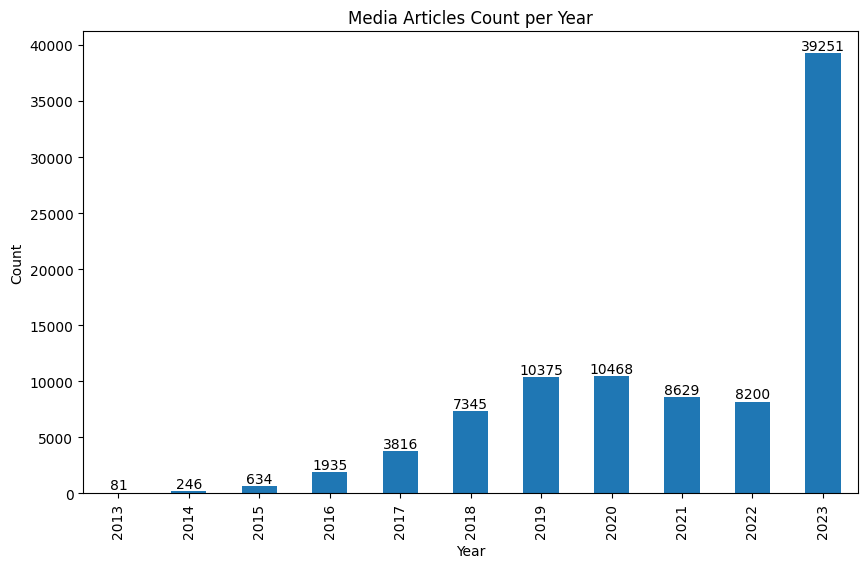

In [43]:
# plotting count of news per year
counts_per_year = data['collect_year'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
ax = counts_per_year.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Media Articles Count per Year')

# Annotate each bar with its count
for i, count in enumerate(counts_per_year):
    ax.text(i, count + 1, str(count), ha='center', va='bottom')

plt.savefig('media-count-year.svg', format='svg')
plt.show()

In [14]:
def filter_space_strings(word_list):
    """
    Removes strings that consist solely of spaces from a list of words.
    """
    filter_words = [' ', '  ', '   ', '    ','        ']  # Define the strings you want to filter out
    return [word for word in word_list if word not in filter_words]

# Apply the filtering function to each row of the 'Cleaned_Body_sw' and 'Cleaned_Title_sw' columns
data['Cleaned_Body_sw'] = data['Cleaned_Body_sw'].apply(filter_space_strings)
data['Cleaned_Title_sw'] = data['Cleaned_Title_sw'].apply(filter_space_strings)

In [20]:
## counting words
from collections import Counter

body_words = [word for words in data['Cleaned_Body_sw'] for word in words] 
title_words = [word for words in data['Cleaned_Title_sw'] for word in words]

body_word_freq = Counter(body_words)
title_word_freq = Counter(title_words)

body_word_freq_dict = dict(body_word_freq)
title_word_freq_dict = dict(title_word_freq)

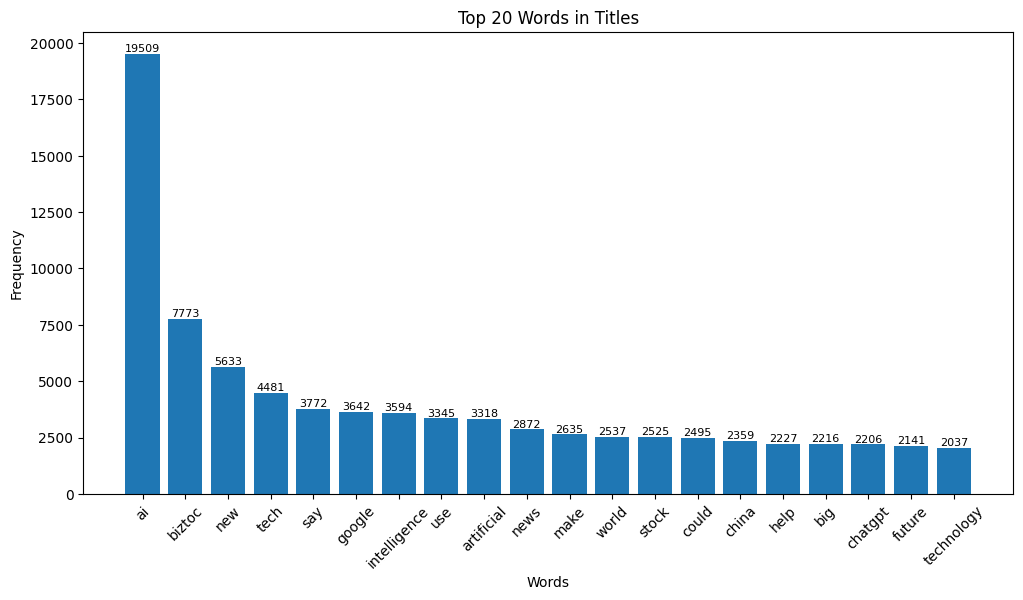

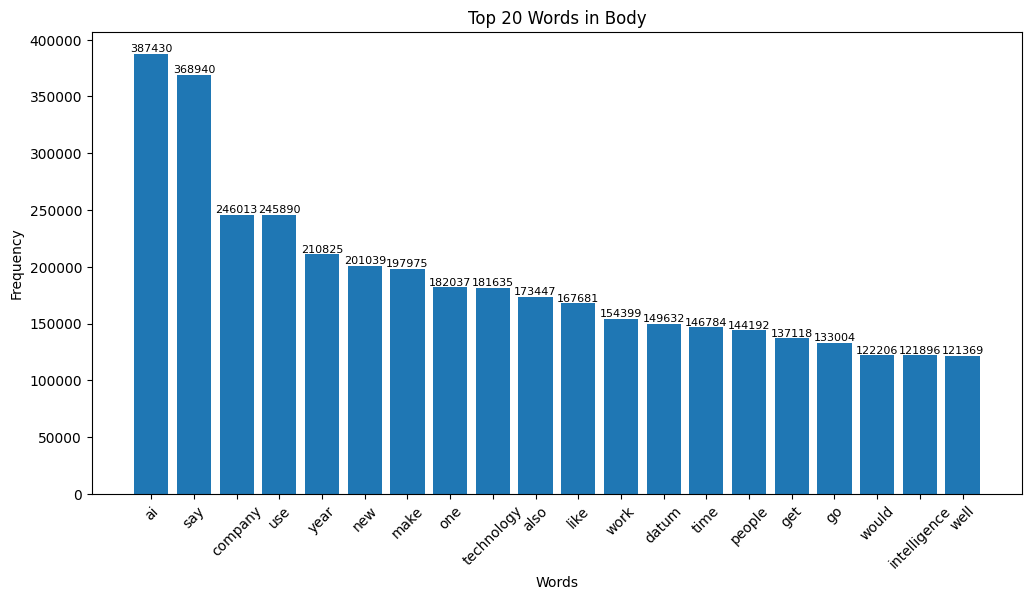

In [21]:
from collections import Counter
import matplotlib.pyplot as plt

# Assuming body_word_freq and title_word_freq are Counter objects or similar
# If they are dictionaries, convert them to Counter objects for simplicity
body_word_freq = Counter(body_word_freq)
title_word_freq = Counter(title_word_freq)

#filter_words = ['   ','  ',' ','']

# Filter out specific words and get the most common 20
filtered_body_common_words = Counter({word: count for word, count in body_word_freq.items()})
filtered_title_common_words = Counter({word: count for word, count in title_word_freq.items()})

# Plot the most common words in titles
title_common_words = filtered_title_common_words.most_common(20)
title_word, title_count = zip(*title_common_words)

plt.figure(figsize=(12, 6))
plt.bar(title_word, title_count)
plt.title("Top 20 Words in Titles")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=90,fontsize=14)

# # Annotate each bar with its count (smaller font size)
# for i, count in enumerate(title_count):
#     plt.text(i, count + 0.1, str(count), ha='center', va='bottom', fontsize=8)

plt.savefig('top-20-words-title.svg', format='svg')
plt.show()

# Plot the most common words in bodies
abstract_common_words = filtered_body_common_words.most_common(20)
abstract_word, abstract_count = zip(*abstract_common_words)

plt.figure(figsize=(12, 6))
plt.bar(abstract_word, abstract_count)
plt.title("Top 20 Words in Body")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=90,fontsize=14)

# # Annotate each bar with its count
# for i, count in enumerate(abstract_count):
#     plt.text(i, count + 0.1, str(count), ha='center', va='bottom', fontsize=8)

plt.savefig('top-20-words-body.svg', format='svg')

plt.show()

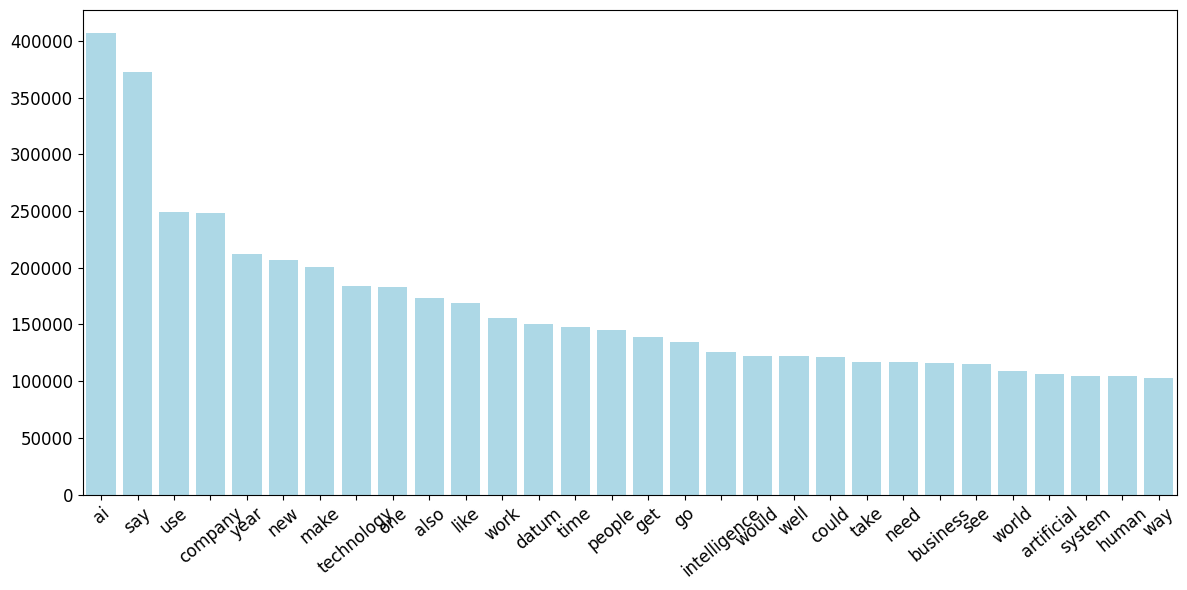

In [22]:
import matplotlib.pyplot as plt
from nltk.probability import FreqDist

# Assuming title_words and body_words are defined and combined into all_tokens
all_tokens = body_word_freq + title_word_freq
freq_dist = FreqDist(all_tokens)

# Get the most common words and their frequencies for plotting
most_common_words = freq_dist.most_common(30)  # Adjust N as needed
words, frequencies = zip(*most_common_words)  # Unpacks list of tuples

# Prepare the data for a bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(words)), frequencies, color='lightblue')  # Create a bar chart

# Adjust x-axis limits to remove space before the first bar and after the last one
plt.xlim(-0.5, len(words) - 0.5)

# Set x-ticks, rotate labels for readability, and set font size
plt.xticks(range(len(words)), words, rotation=90, fontsize=14)
plt.yticks(fontsize=12)

plt.tight_layout()

plt.savefig('top-30-words-media.svg', format='svg')
# Show the plot
plt.show()


## Part 2: Bigrams
    Exploring which words act like collocations grammarly in my corpus
---

In [15]:
#make sure to lowercase everything
title_lemma = data.Cleaned_Title_sw
body_lemma = data.Cleaned_Body_sw

all_text = title_lemma+body_lemma

In [16]:
#turn all text' tokens into one single list
unlist_comments = [item for items in all_text for item in items]

In [17]:
unlist_comments

['top',
 'stock',
 'buy',
 'markets',
 'react',
 'infrastructure',
 'plan',
 'news',
 'drive',
 'force',
 'behind',
 'market',
 'current',
 'performance',
 'investor',
 'take',
 'advantage',
 'rally',
 'market',
 'look',
 'direction',
 'wednesday',
 'big',
 'rally',
 'yesterday',
 'market',
 'grow',
 'assumption',
 'bad',
 'may',
 'us',
 'economy',
 'lead',
 'decline',
 'today',
 'airline',
 'cruise',
 'operator',
 'investor',
 'look',
 'take',
 'recent',
 'gain',
 'table',
 'market',
 'surge',
 'yesterday',
 'strong',
 'expect',
 'retail',
 'report',
 'may',
 'well',
 'bloomberg',
 'news',
 'report',
 'trump',
 'administration',
 'prepare',
 '1',
 'trillion',
 'infrastructure',
 'bill',
 'addition',
 'positive',
 'trial',
 'result',
 'widely',
 'available',
 'drug',
 'dexamethasone',
 'could',
 'help',
 'critically',
 'ill',
 'coronavirus',
 'patient',
 'backstoppe',
 'market',
 'currently',
 'deep',
 'learning',
 'algorithm',
 'pair',
 'artificial',
 'intelligence',
 'ai',
 'technolo

### Initialize NLTK's Bigrams/Trigrams Finder

In [18]:
bigrams = nltk.collocations.BigramAssocMeasures()

In [19]:
bigramFinder = nltk.collocations.BigramCollocationFinder.from_words(unlist_comments)

### 1. Counting Frequencies of Adjacent Words
- Main idea: simply order by frequency
- Issues: too sensitive to very frequent pairs and pronouns/articles/prepositions come up often
- Solution: filter for only adjectives and nouns

In [21]:
bigram_freq = bigramFinder.ngram_fd.items()
bigramFreqTable = pd.DataFrame(list(bigram_freq), columns=['bigram','freq']).sort_values(by='freq', ascending=False)
bigramFreqTable.head(50).reset_index(drop=True)

,bigram,freq
0,"(artificial, intelligence)",102009
1,"(social, medium)",24071
2,"(generative, ai)",22564
3,"(last, year)",22425
4,"(use, ai)",19952
5,"(new, york)",19643
6,"(machine, learning)",18296
7,"(year, ago)",18177
8,"(united, states)",17254
9,"(machine, learn)",14745


In [22]:
#function to filter for ADJ/NN bigrams
def rightTypes(ngram):
    if '-pron-' in ngram or '' in ngram or ' 'in ngram or 't' in ngram:
        return False
    for word in ngram:
        if word in stop_words:
            return False
    acceptable_types = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    second_type = ('NN', 'NNS', 'NNP', 'NNPS')
    tags = nltk.pos_tag(ngram)
    if tags[0][1] in acceptable_types and tags[1][1] in second_type:
        return True
    else:
        return False

In [23]:
#filter bigrams
filtered_bi = bigramFreqTable[bigramFreqTable.bigram.map(lambda x: rightTypes(x))]
filtered_bi.head().reset_index(drop=True)
filtered_bi.to_csv('bigram_news.csv')

In [24]:
filtered_bi.head(50)

,bigram,freq
84,"(artificial, intelligence)",102009
6083,"(social, medium)",24071
41826,"(generative, ai)",22564
206,"(last, year)",22425
10940,"(use, ai)",19952
8070,"(new, york)",19643
2842,"(machine, learning)",18296
1362,"(united, states)",17254
4297,"(machine, learn)",14745
255,"(ai, system)",13650


In [13]:
# Filter top 100 bigrams
top_100_bigrams = bigrams.sort_values(by='freq', ascending=False).head(100)
top_100_bigrams

,Unnamed: 0,bigram,freq
0,84,"('artificial', 'intelligence')",102009
1,6083,"('social', 'medium')",24071
2,41826,"('generative', 'ai')",22564
3,206,"('last', 'year')",22425
4,10940,"('use', 'ai')",19952
...,...,...,...
95,67189,"('video', 'game')",4071
96,10298,"('answer', 'question')",4036
97,4336,"('language', 'processing')",4016
98,1361874,"('image', 'credit')",4010


In [14]:
# Simple function to convert bigram strings
def simple_convert_bigram(bigram_str):
    # Split the string by comma, remove unwanted characters, and join with an underscore
    return '_'.join(bigram_str.replace("('", "").replace("')", "").replace("'", "").split(", "))

# Apply the conversion function to each bigram
top_100_bigrams['bigram'] = top_100_bigrams['bigram'].apply(simple_convert_bigram)

# Now `df['bigram']` contains the bigrams in the desired format
print(top_100_bigrams.head())

   Unnamed: 0                   bigram    freq
0          84  artificial_intelligence  102009
1        6083            social_medium   24071
2       41826            generative_ai   22564
3         206                last_year   22425
4       10940                   use_ai   19952


In [18]:
# Convert the 'bigram' column to a list
bigrams_list = bigrams['bigram'].tolist()

## NER to categorize the bigrams
    This analysis I didn't use it in the final document, but I'm leaving it here because why not
---

In [62]:
def categorize_bigram(bigram):
    # Categories and their associated bigrams
    categories = {
        "Artificial Intelligence & Technology": [
            'artificial_intelligence', 'generative_ai', 'use_ai', 'machine_learning', 'machine_learn', 'ai_system',
            'tech_company', 'intelligence_ai', 'facial_recognition', 'deep_learning', 'ai_tool', 'ai_technology',
            'language_model', 'ai_model', 'ai_generate', 'essential_ai', 'arm_chips', 'ai_phones', 'open_source',
            'natural_language', 'digital_transformation', 'large_language', 'tech_giant', 'use_technology',
            'computer_science', 'self_driving', 'business_model', 'next_generation', 'ai_use', 'technology_company',
            'privacy_policy', 'language_processing', 'image_credit','drive_car', 'answer_question', 'amp_amp', 'video_game'
        ],
        "Geographical Locations": [
            'new_york', 'united_states', 'white_house', 'silicon_valley', 'wall_street', 'san_francisco',
            'los_angeles', 'u_k'
        ],
        "People": [
            'elon_musk', 'vice_president', 'co_founder', 'donald_trump', 'joe_biden', 'chief_executive',
            'biden_administration','phones_ceo','use_case'
        ],
        "Business & Economy": [
            'fiscal_year', 'supply_chain', 'national_security', 'climate_change', 'customer_service',
            'law_enforcement', 'e_commerce', 'datum_center', 'customer_experience', 'medium_platform',
            'interest_rate', 'real_estate', 'business_model', 'decision_make'
        ],
        "Society & Culture": [
            'social_medium', 'health_care', 'climate_change', 'sag_aftra', 'common_myth', 'world_creativity',
            'myth_genius', 'divine_inspiration', 'genius_strike', 'real_world', 'mental_health',
            'washington_post', 'york_times','fox_news', 'many_people'
        ],
        "Time": [
            'last_year', 'last_week', 'long_term', 'first_time','last_month', 'next_year',
            'third_party', 'early_year',
            'recent_year', 'make_sense'
        ]
    }

    # Determine the category for the given bigram
    for category, bigrams in categories.items():
        if bigram in bigrams:
            return category
    return "Uncategorized"  # Return this if the bigram doesn't fit in any category

# Example usage
# Assuming df is your DataFrame and 'bigram' is the column with bigrams
top_100_bigrams['category'] = top_100_bigrams['bigram'].apply(categorize_bigram)


In [63]:
top_100_bigrams.head()


,Unnamed: 0,bigram,freq,category,Log_Freq,log_freq
0,84,artificial_intelligence,102009,Artificial Intelligence & Technology,11.532816,11.532816
1,6083,social_medium,24071,Society & Culture,10.088763,10.088763
2,41826,generative_ai,22564,Artificial Intelligence & Technology,10.024111,10.024111
3,206,last_year,22425,Time,10.017932,10.017932
4,10940,use_ai,19952,Artificial Intelligence & Technology,9.901085,9.901085


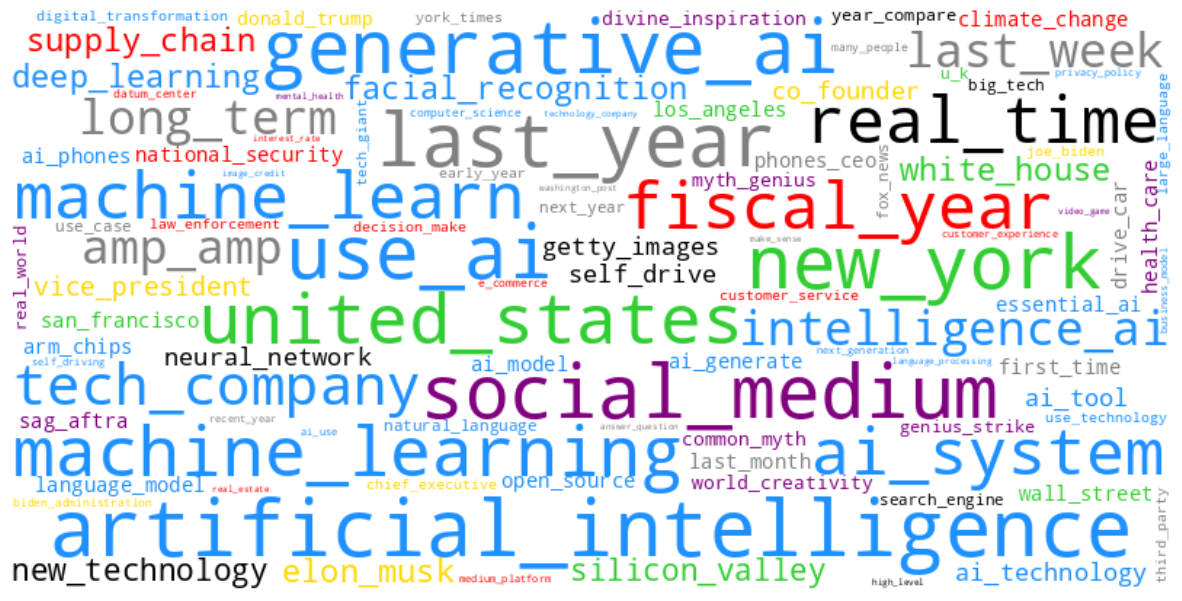

In [40]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
import pandas as pd

# Assuming 'df' is your DataFrame after categorization and it includes a 'Freq' column for frequency
# Let's add a logarithmic frequency column to the DataFrame for better visualization
top_100_bigrams['Log_Freq'] = np.log(top_100_bigrams['freq'])

# Define a color map based on categories
category_colors = {
    'Artificial Intelligence & Technology': 'dodgerblue',
    'Geographical Locations': 'limegreen',
    'People': 'gold',
    'Business & Economy': 'red',
    'Society & Culture': 'purple',
    'Time': 'grey',
    'Uncategorized': 'black'  # In case there are any uncategorized bigrams
}

# Function to apply colors based on categories
def color_func(word, **kwargs):
    category = top_100_bigrams[top_100_bigrams['bigram'] == word]['category'].values[0]
    return category_colors.get(category, 'black')

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func)

# Prepare the frequencies in the correct format for the word cloud
frequencies = {row['bigram']: row['Log_Freq'] for index, row in top_100_bigrams.iterrows()}
wordcloud.generate_from_frequencies(frequencies)

# Plot
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


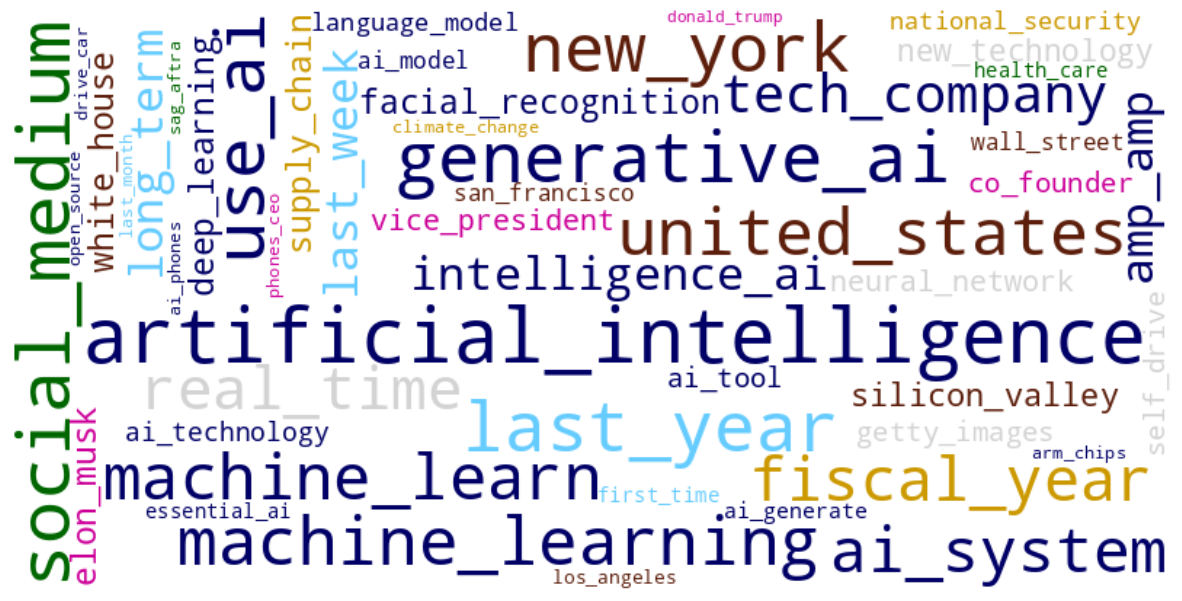

In [80]:
# Assuming you have your 'top_100_bigrams' DataFrame already set up

category_colors = {
    'Artificial Intelligence & Technology': '#000066',
    'Geographical Locations': '#5d1f0c',
    'People': '#cc0099',
    'Business & Economy': '#cc9900',
    'Society & Culture': '#006600',
    'Time': '#66ccff',
    'Uncategorized': 'lightgrey'
}

# Ensure the DataFrame has a 'log_freq' column
top_100_bigrams['log_freq'] = np.log(top_100_bigrams['freq'])

# Sort the DataFrame by the 'log_freq' in descending order and take the top 50
top_bigrams = top_100_bigrams.sort_values(by='log_freq', ascending=False).head(50)

# Create a mapping of the top bigrams to their colors using the DataFrame
bigram_to_color = {bigram: category_colors[category] for bigram, category in zip(top_bigrams['bigram'], top_bigrams['category'])}

# Define a custom color function to use with the word cloud
def custom_color_func(word, *args, **kwargs):
    return bigram_to_color.get(word, 'lightgrey')  # Default to 'lightgrey' if the word is not found

# Create a word cloud with mixed orientations
wordcloud = WordCloud(width=800, height=400, prefer_horizontal=0.2, color_func=custom_color_func, background_color='white')

# Generate the word cloud using the top bigrams' frequencies
wordcloud.generate_from_frequencies(dict(zip(top_bigrams['bigram'], top_bigrams['log_freq'])))

# Save the word cloud as PNG
wordcloud.to_file('wordcloud-media.png')

# Display the word cloud
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


## W2V

In [56]:
# Combine the two columns into one
data['combined_text'] = data['Cleaned_Body_sw'] + data['Cleaned_Title_sw']

In [57]:
from nltk.tokenize import word_tokenize
## Keeping certain n-grams together for later NN analysis

# Define  n-grams
n_grams_to_keep = [
    "neural network",
    "deep learning",
    "reinforcement learning",
    "supervised learning",
    "unsupervised learning",
    "generative model",
    "natural language processing",
    "artificial intelligence"
]

# Function to replace spaces with underscores in n-grams
def preserve_n_grams(tokens, n_grams_to_keep):
    n_grams_dict = {n_gram: n_gram.replace(' ', '_') for n_gram in n_grams_to_keep}
    new_tokens = []
    tokens = ' '.join(tokens)  # Convert list of tokens to a single string to make replacement easier
    for n_gram, n_gram_with_underscore in n_grams_dict.items():
        tokens = tokens.replace(n_gram, n_gram_with_underscore)
    new_tokens = tokens.split()  # Split the string back into a list
    return new_tokens

data['combined_text'] = data['combined_text'].apply(lambda x: preserve_n_grams(x, n_grams_to_keep))

In [58]:
data

,ID,URL,Body,Title,media_name,publish_date,stories_id,story_tags,Summary,Cleaned_Body,Cleaned_Title,collect_date_,collect_year,collect_month,Cleaned_Body_sw,Cleaned_Title_sw,combined_text
0,1637524801,https://www.forbes.com/sites/qai/2020/06/17/to...,The news is the driving force behind the marke...,Top Stocks To Buy As Markets React To Infrastr...,Forbes,2020-06-17 13:43:25,1637524801,"[{'stories_id': 1637524801, 'tag': 'geonames_6...",NaN,"[the, news, be, the, drive, force, behind, the...","[top, stock, to, buy, as, markets, react, to, ...",2020-06-17 14:01:13.920648,2020,6,"[news, drive, force, behind, market, current, ...","[top, stock, buy, markets, react, infrastructu...","[news, drive, force, behind, market, current, ..."
1,1637524795,https://www.forbes.com/sites/qai/2020/06/17/to...,June has been a tumultuous month for Nasdaq bu...,Top Companies To Short As Nasdaq Looks To Brea...,Forbes,2020-06-17 13:52:21,1637524795,"[{'stories_id': 1637524795, 'tag': 'nyt_labell...",NaN,"[june, have, be, a, tumultuous, month, for, na...","[top, company, to, short, as, nasdaq, look, to...",2020-06-17 14:01:13.771916,2020,6,"[june, tumultuous, month, nasdaq, look, poise,...","[top, company, short, nasdaq, look, break, 10,...","[june, tumultuous, month, nasdaq, look, poise,..."
2,1637550862,https://www.forbes.com/sites/normananderson/20...,Abstract glitch background\nA critical questio...,Infrastructure Investment - What Is Your Vision?,Forbes,2020-06-17 14:01:02,1637550862,"[{'stories_id': 1637550862, 'tag': 'geonames_6...",NaN,"[abstract, glitch, background, a, critical, qu...","[infrastructure, investment, , what, be, you...",2020-06-17 14:31:02.283201,2020,6,"[abstract, glitch, background, critical, quest...","[infrastructure, investment, , vision]","[abstract, glitch, background, critical, quest..."
3,1637550855,https://www.forbes.com/sites/alexkonrad/2020/0...,"Sam Altman, bottom right, has launched a new f...",Altman Brothers Band: Sam Altman’s Newest Proj...,Forbes,2020-06-17 14:06:09,1637550855,"[{'stories_id': 1637550855, 'tag': 'geonames_6...",NaN,"[sam, altman, , bottom, right, , have, launc...","[altman, brothers, band, , sam, altman, s, ne...",2020-06-17 14:31:02.191748,2020,6,"[sam, altman, , bottom, right, , launch, new...","[altman, brothers, band, , sam, altman, newes...","[sam, altman, bottom, right, launch, new, fund..."
4,1638141352,https://www.forbes.com/sites/worldeconomicforu...,"By Richard Samans, Managing Director of the Wo...",Integrated Corporate Governance: Six Leadershi...,Forbes,2020-06-18 06:00:00,1638141352,[],NaN,"[by, richard, samans, , managing, director, o...","[integrated, corporate, governance, , six, le...",2020-06-18 06:04:27.719088,2020,6,"[richard, samans, , managing, director, world...","[integrated, corporate, governance, , six, le...","[richard, samans, managing, director, world, e..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90975,302055705,http://www.politico.com/morningmoney/1214/morn...,Romney/Bush lead in GOP poll — Russia hikes ra...,Romney/Bush lead in GOP poll — Russia hikes ra...,Politico,2014-12-16 13:00:23,302055705,[],Romney/Bush lead in GOP poll — Russia hikes ra...,"[romney, bush, lead, in, gop, poll, , russia...","[romney, bush, lead, in, gop, poll, , russia...",2014-12-16 20:46:51.000000,2014,12,"[romney, bush, lead, gop, poll, , russia, hi...","[romney, bush, lead, gop, poll, , russia, hi...","[romney, bush, lead, gop, poll, russia, hike, ..."
90976,859682618,http://www.businessinsider.com/artificial-inte...,Ray Dalio. Larry Busacca/Getty\n\nThe world's ...,Billionaire hedge fund manager Ray Dalio — who...,Business Insider,2015-02-27 07:00:00,859682618,"[{'stories_id': 859682618, 'tag': 'spidered', ...",Larry Busacca/GettyThe world's largest hedge f...,"[ray, dalio, , larry, busacca, getty, the, wo...","[billionaire, hedge, fund, manager, ray, dalio...",2018-04-26 16:38:52.000000,2018,4,"[ray, dalio, , larry, busacca, getty, world, ...","[bill

In [62]:
# Prepare the list of tokenized texts for Word2Vec
from gensim.models import Word2Vec

# Prepare the sentences for Word2Vec
sentences = data['combined_text'].tolist()

# Train the Word2Vec model
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4, epochs=10)

# Save the model for later use
model.save("word2vec_model_news.model")

In [60]:
queries = [
    "neural_network",
    "deep_learning",
    "reinforcement_learning",
    "supervised_learning",
    "unsupervised_learning",
    "generative_model",
    "natural_language_processing",
    "artificial_intelligence"
]

# Find and print nearest neighbors for each query
for query in queries:
    if query in model.wv.key_to_index:
        print(f"Nearest neighbors for '{query}':")
        for word, similarity in model.wv.most_similar(query, topn=10):
            print(f"{word}: {similarity:.4f}")
        print()
    else:
        print(f"'{query}' not found in vocabulary.")

Nearest neighbors for 'neural_network':
neural_networks: 0.8593
dnn: 0.8049
convolutional: 0.8004
deep_learning: 0.7780
rnn: 0.7711
convolution: 0.7509
snn: 0.7326
gan: 0.7291
reinforcement_learning: 0.7252
neural: 0.7227

Nearest neighbors for 'deep_learning':
neural_network: 0.7780
ml: 0.7557
unsupervised_learning: 0.7361
neural_networking: 0.7150
neural_networks: 0.7133
reinforcement_learning: 0.7051
dnn: 0.7041
nlp: 0.6745
clustering: 0.6688
natural_language_processing: 0.6630

Nearest neighbors for 'reinforcement_learning':
rl: 0.7911
unsupervised_learning: 0.7602
neural_network: 0.7252
rlhf: 0.7084
deep_learning: 0.7051
reinforcement: 0.6888
neural_networks: 0.6803
unsupervised: 0.6748
supervised_learning: 0.6711
supervised: 0.6647

Nearest neighbors for 'supervised_learning':
supervised: 0.8413
unsupervised_learning: 0.8202
unsupervised: 0.7915
supervise: 0.6901
unsupervise: 0.6804
reinforcement_learning: 0.6711
neural_network: 0.6501
deep_learning: 0.6334
clustering: 0.6291
bay

In [ ]:
# Open a file to write the nearest neighbors
with open("nearest_neighbors_news.txt", "w") as file:
    for query in queries:
        if query in model.wv.key_to_index:
            file.write(f"Nearest neighbors for '{query}':\n")
            for word, similarity in model.wv.most_similar(query, topn=10):
                file.write(f"{word}: {similarity:.4f}\n")
            file.write("\n")
        else:
            file.write(f"'{query}' not found in vocabulary.\n")

print("Nearest neighbors saved to 'nearest_neighbors_news.txt'.")

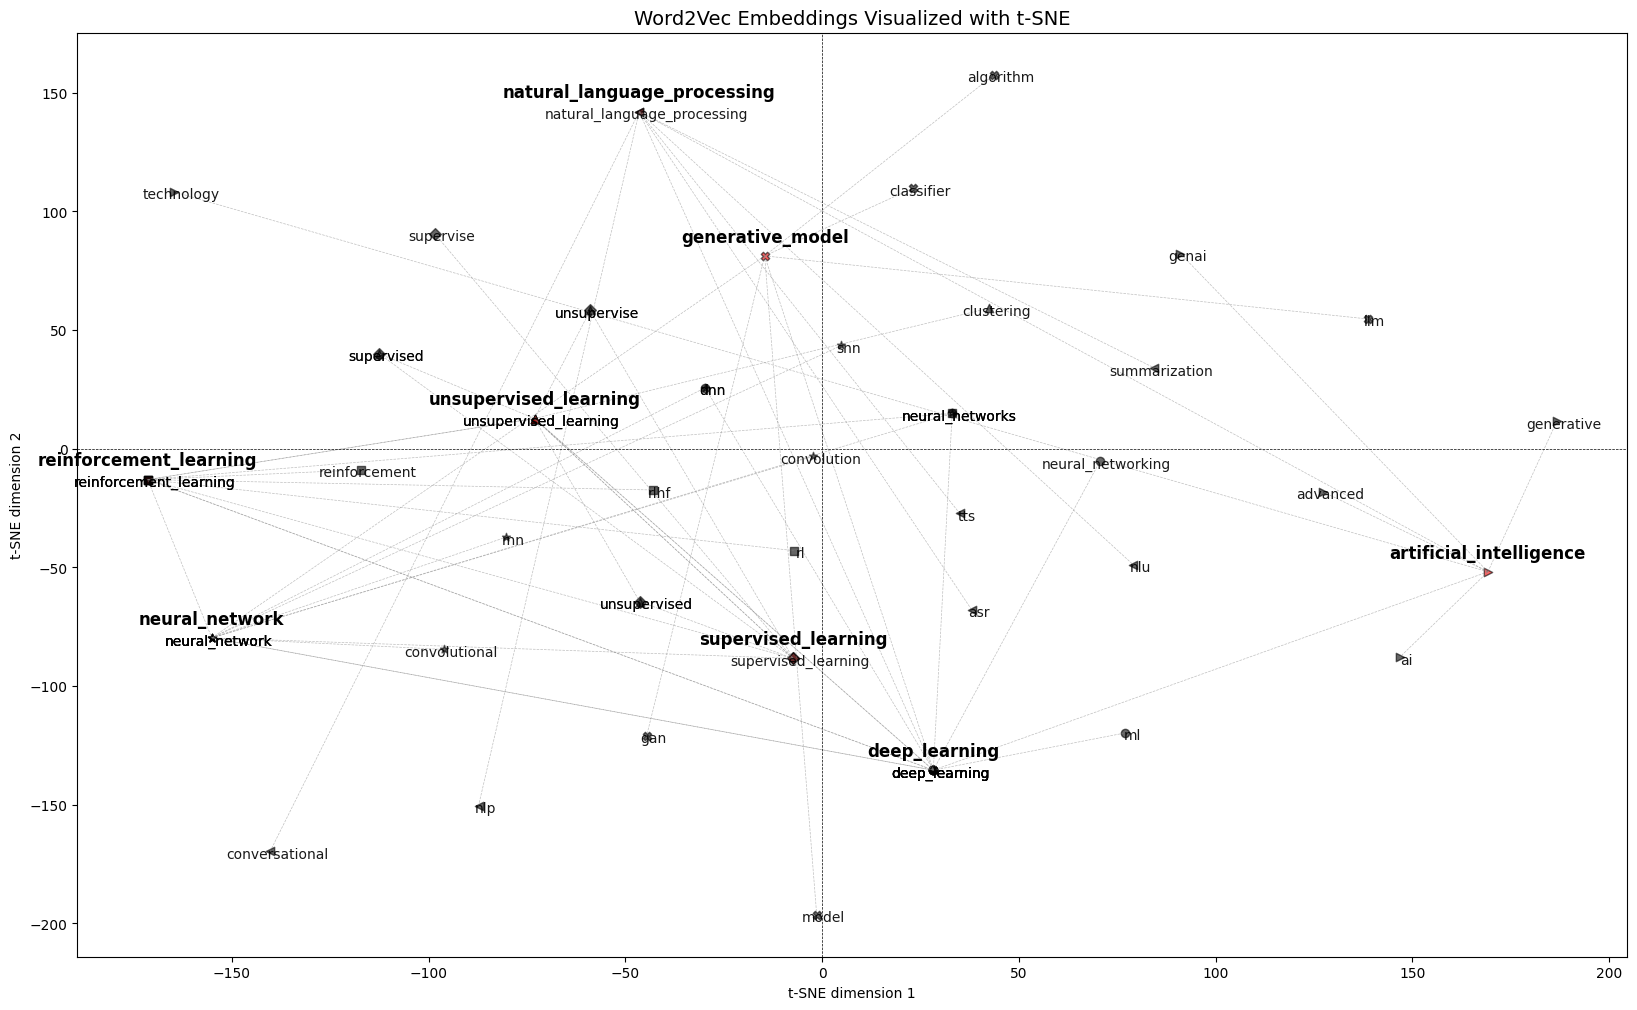

In [81]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle

# Define marker cycle
markers = cycle(['*', 'o', 's', 'D', '^','X', '<','>'])  # Extend with more markers if needed

# Map each query to a unique marker and retrieve top 5 nearest neighbors
query_to_marker = {}
all_words = set()
query_to_nn = {}

for query in queries:
    query_to_marker[query] = next(markers)
    nn = [word for word, _ in model.wv.most_similar(query, topn=7)]
    query_to_nn[query] = nn
    all_words.update([query] + nn)

# Prepare word vectors and mapping for t-SNE
words = list(all_words)
word_vectors = np.array([model.wv[word] for word in words])
word_to_index = {word: i for i, word in enumerate(words)}

# t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200, n_iter=3000)
word_vectors_2d = tsne.fit_transform(word_vectors)

# Plotting
plt.figure(figsize=(20, 12))

for query in queries:
    query_index = word_to_index[query]
    query_x, query_y = word_vectors_2d[query_index]
    plt.scatter(query_x, query_y, color='red', marker=query_to_marker[query], alpha=0.6, edgecolor='k')
    # Increase the font size for the query annotations
    plt.annotate(query, (query_x, query_y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12, weight='bold')

    for nn in query_to_nn[query]:
        nn_index = word_to_index[nn]
        nn_x, nn_y = word_vectors_2d[nn_index]
        # NN style checks
        if nn in queries:  # NN is also a query
            marker_style = query_to_marker[nn]
        else:
            marker_style = query_to_marker[query]  # Use the same marker as the query for visual grouping

        plt.scatter(nn_x, nn_y, color='black', marker=marker_style, alpha=0.6)
        plt.plot([query_x, nn_x], [query_y, nn_y], color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
        
        # Increase the font size for the NN annotations
        plt.annotate(nn, (nn_x, nn_y), textcoords="offset points", xytext=(5,-5), ha='center', fontsize=10, alpha=0.9)

plt.title("Word2Vec Embeddings Visualized with t-SNE", fontsize=14)
# Show the axes
plt.axhline(y=0, color='k', linestyle='--', linewidth=0.5)
plt.axvline(x=0, color='k', linestyle='--', linewidth=0.5)
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')

plt.savefig('nn_tsne_media.svg')

plt.show()

---
End of script